<h1 align=center><font size=5>Chronic Kidney Disease (CKD)</font></h1>

## Predictive Model <a id = 'stats_func'></a> (by RNN Networks)

### Using the longitudinal data of different lab measurements and the time it got conducted<a id = 'avg_measure'></a>

#### Path

The path to the current opened notebook.

In [1]:
import os
os.getcwd()
#os.chdir('../../../Desktop/Lucas_PostDoc/')
#os.getcwd()

'C:\\Users\\jetin\\Desktop\\Holmusk_Interview'

#### Packages needed

The packages is loaded which will be useful in the analysis.

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.layers import LSTM, Input,  Reshape, Dropout, Activation
from keras.layers import SimpleRNN
from keras.models import Model
import tensorflow as tf

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from cwrnn import ClockworkRNN

#### Data File loaded

The data file containing the longitudinal data of lab measurements and its time is loaded here and the information in the file is displayed.

In [4]:
nRowsRead = 2000 # specify 'None' if want to read whole file
# Hourly-test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('./dataScienceTask/T_creatinine.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'T_creatinine.csv'
nRow_tn, nCol_tn = df1.shape
print("----------------------------------------------------")
print(f'There are {nRow_tn} rows and {nCol_tn} columns for creatinine')
print(df1.describe())
print("----------------------------------------------------")

nRowsRead = 2000 # specify 'None' if want to read whole file
# Hourly-test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('./dataScienceTask/T_DBP.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'T_DBP.csv'
nRow_tn, nCol_tn = df2.shape
print(f'There are {nRow_tn} rows and {nCol_tn} columns for DBP')
print(df2.describe())
print("----------------------------------------------------")

nRowsRead = 2000 # specify 'None' if want to read whole file
# Hourly-test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('./dataScienceTask/T_glucose.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'T_glucose.csv'
nRow_tn, nCol_tn = df3.shape
print(f'There are {nRow_tn} rows and {nCol_tn} columns for glucose')
print(df3.describe())
print("----------------------------------------------------")

nRowsRead = 3000 # specify 'None' if want to read whole file
# Hourly-test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df4 = pd.read_csv('./dataScienceTask/T_HGB.csv', delimiter=',', nrows = nRowsRead)
df4.dataframeName = 'T_HGB.csv'
nRow_tn, nCol_tn = df4.shape
print(f'There are {nRow_tn} rows and {nCol_tn} columns for HGB')
print(df4.describe())
print("----------------------------------------------------")

nRowsRead = 3000 # specify 'None' if want to read whole file
# Hourly-test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df5 = pd.read_csv('./dataScienceTask/T_ldl.csv', delimiter=',', nrows = nRowsRead)
df5.dataframeName = 'T_ldl.csv'
nRow_tn, nCol_tn = df5.shape
print(f'There are {nRow_tn} rows and {nCol_tn} columns for 1dl')
print(df5.describe())
print("----------------------------------------------------")

nRowsRead = 2000 # specify 'None' if want to read whole file
# Hourly-test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df6 = pd.read_csv('./dataScienceTask/T_SBP.csv', delimiter=',', nrows = nRowsRead)
df6.dataframeName = 'T_SBP.csv'
nRow_tn, nCol_tn = df6.shape
print(f'There are {nRow_tn} rows and {nCol_tn} columns for SBP')
print(df6.describe())
print("----------------------------------------------------")

----------------------------------------------------
There are 1439 rows and 3 columns for creatinine
                id        value         time
count  1439.000000  1439.000000  1439.000000
mean    148.706046     1.328999   293.828353
std      87.180040     0.357971   223.600131
min       0.000000     0.240000     0.000000
25%      73.500000     1.080000    84.000000
50%     149.000000     1.290000   296.000000
75%     225.000000     1.530000   488.500000
max     299.000000     3.020000   699.000000
----------------------------------------------------
There are 1821 rows and 3 columns for DBP
                id        value         time
count  1821.000000  1821.000000  1821.000000
mean    149.403624    79.518583   305.311917
std      87.045934    10.178676   221.674079
min       0.000000    44.950000     0.000000
25%      74.000000    72.830000    97.000000
50%     150.000000    79.050000   301.000000
75%     226.000000    86.170000   496.000000
max     299.000000   112.930000   699.

#### Data File loaded

The data file containing the output information is loaded here whether the considered patient will progress in CKD or not.

In [5]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Hourly-test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df7 = pd.read_csv('./dataScienceTask/T_stage.csv', delimiter=',', nrows = nRowsRead)
df7.dataframeName = 'T_stage.csv'
nRow_tn, nCol_tn = df7.shape
print("----------------------------------------------------")
print(f'There are {nRow_tn} rows and {nCol_tn} columns for stage progress')
print(df7['Stage_Progress'].value_counts())
print("----------------------------------------------------")

----------------------------------------------------
There are 300 rows and 2 columns for stage progress
False    200
True     100
Name: Stage_Progress, dtype: int64
----------------------------------------------------


#### Matrix consisting of the lab measurements and the conducted time.

A matrix consisting of the lab measurements and the time this measurment is conducted for each person 
in a row of this matrix.

In [6]:
tot_persons=300
data = -np.ones((tot_persons, 3+50*6))
index1 = 0

# C = df.race.unique()
# D = df.gender.unique()

# for i in range(len(C)):
#     df[['race']] = df[['race']].replace(to_replace = C[i], value = i)
      
# for i in range(len(D)):
#     df[['gender']] = df[['gender']].replace(to_replace = D[i], value = i)
        
# print(df)

# list_race = df['race']
# list_gender = df['gender']
# list_age = df['age']
# for person in range(0,tot_persons): 
#     list4 = df.index[df['id'] == person].tolist()
#     for index in range(len(list4)):
#         data[person][0] = list_race[list4[index]]
#         data[person][1] = list_gender[list4[index]]   
#         data[person][2] = list_age[list4[index]]
        
list_time = df1['time']
list_val = df1['value']
for person in range(0,tot_persons): 
    list4 = df1.index[df1['id'] == person].tolist()
    for index in range(len(list4)):
        data[person][index1+index] = list_time[list4[index]]
        data[person][index1+index+25] = list_val[list4[index]]    
        
list_time = df2['time']
list_val = df2['value']
for person in range(0,tot_persons): 
    list4 = df2.index[df2['id'] == person].tolist()
    for index in range(len(list4)):
        data[person][index1+50+index] = list_time[list4[index]]
        data[person][index1+50+index+25] = list_val[list4[index]]    
        
list_time = df3['time']
list_val = df3['value']
for person in range(0,tot_persons): 
    list4 = df3.index[df3['id'] == person].tolist()
    for index in range(len(list4)):
        data[person][index1+50*2+index] = list_time[list4[index]]
        data[person][index1+50*2+index+25] = list_val[list4[index]]    
        
list_time = df4['time']
list_val = df4['value']
for person in range(0,tot_persons): 
    list4 = df4.index[df4['id'] == person].tolist()
    for index in range(len(list4)):
        data[person][index1+50*3+index] = list_time[list4[index]]
        data[person][index1+50*3+index+25] = list_val[list4[index]]            
        
list_time = df5['time']
list_val = df5['value']
for person in range(0,tot_persons): 
    list4 = df5.index[df5['id'] == person].tolist()
    for index in range(len(list4)):
        data[person][index1+50*4+index] = list_time[list4[index]]
        data[person][index1+50*4+index+25] = list_val[list4[index]]       
        
list_time = df6['time']
list_val = df6['value']
for person in range(0,tot_persons): 
    list4 = df6.index[df6['id'] == person].tolist()
    for index in range(len(list4)):
        data[person][index1+50*5+index] = list_time[list4[index]]
        data[person][index1+50*5+index+25] = list_val[list4[index]]

print("------------------------------------------------------------")        
print(data) 
print("------------------------------------------------------------")

S = np.sum(data,0)
S_index = np.where(S == -300)
#print(S)
print(S_index)
print("------------------------------------------------------------")
data = np.delete(data,S_index,1)
print(data)
print("------------------------------------------------------------")
S = np.sum(data,0)
S_index = np.where(S == -300)
#print(S)
#print(S_index)

------------------------------------------------------------
[[  0. 107. 286. ...  -1.  -1.  -1.]
 [  0.  68. 289. ...  -1.  -1.  -1.]
 [  0. 184. 430. ...  -1.  -1.  -1.]
 ...
 [  0. 117. 303. ...  -1.  -1.  -1.]
 [  0.  86. 217. ...  -1.  -1.  -1.]
 [  0. 531. 652. ...  -1.  -1.  -1.]]
------------------------------------------------------------
(array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 172, 173, 174, 197, 198, 199, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 233, 234,
 

#### Standardization of the data along the row

The data is standardized using StandardScaler or MinMaxScaler along the row before inputting the data into the neural network.

In [7]:
scaler = StandardScaler().fit(data.T)

A = scaler.transform(data.T)

data = A.T
print("------------------------------------------------------------")
print(data.shape)
print("------------------------------------------------------------")
print(data[0])
print("------------------------------------------------------------")

------------------------------------------------------------
(300, 134)
------------------------------------------------------------
[-0.566938   -0.130906    0.5985307   0.98973698  1.79659992  2.23670698
 -0.57101306 -0.57101306 -0.57101306 -0.57101306 -0.56168116 -0.56225167
 -0.5610699  -0.56192567 -0.56253693 -0.56192567 -0.57101306 -0.57101306
 -0.57101306 -0.57101306 -0.566938   -0.16758159  0.57000524  0.98158685
  1.36871806  1.79659992  2.19595633  2.20003139 -0.57101306 -0.57101306
 -0.57101306 -0.17850276 -0.22471401 -0.29810593 -0.22703679 -0.2148931
 -0.20979927 -0.24749362 -0.22345074 -0.57101306 -0.57101306 -0.57101306
 -0.566938   -0.130906    0.5985307   0.98973698  1.79659992  2.23670698
 -0.57101306 -0.57101306 -0.54150959 -0.53759753 -0.53837179 -0.5388608
 -0.54403613 -0.54338412 -0.57101306 -0.57101306 -0.566938   -0.130906
  0.5985307   0.98973698  2.23670698  2.62383819  3.04764499  3.81783235
  4.30684019 -0.57101306 -0.57101306 -0.57101306 -0.57101306 -0.5710

#### Splitting and preprocessing the Matrix

The constructed matrix from lab measurements and the time is split into training and testing input set.   
Similarly, the data on the patient will progress in CKD or not is converted to 1 and 0 respectively and then the data is split into training and testing output set.

In [8]:
labels=data
features = df7[['Stage_Progress']].astype(np.float32)

#one_hot_encoded_data = pd.get_dummies(df8[['Stage_Progress']], columns = ['Stage_Progress'])
#print(one_hot_encoded_data)

#features = one_hot_encoded_data.astype(np.float32)



X_train, X_test, y_train, y_test = train_test_split(labels, features, test_size=0.1, random_state=42) 

print("------------------------------------------------------------")
print(y_test)
print("------------------------------------------------------------")

------------------------------------------------------------
     Stage_Progress
203             0.0
266             0.0
152             0.0
9               0.0
233             0.0
226             0.0
196             0.0
109             1.0
5               0.0
175             0.0
237             1.0
57              1.0
218             1.0
45              1.0
182             1.0
221             1.0
289             0.0
211             0.0
148             0.0
165             1.0
78              0.0
113             1.0
249             0.0
250             0.0
104             1.0
42              1.0
281             1.0
295             1.0
157             0.0
238             0.0
------------------------------------------------------------


#### Standardization of the data

The data is standardized using StandardScaler or MinMaxScaler before inputting the data into the neural network.

In [9]:
scaler = StandardScaler().fit(X_train)

A = scaler.transform(X_train)

B = scaler.transform(X_test)  

X_train = A

X_test = B

# X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
# X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print("------------------------------------------------------------")
print(X_train)
print("------------------------------------------------------------")

------------------------------------------------------------
[[-0.96508906 -1.35493188 -0.60816634 ...  1.21516779  1.23043748
   3.04946829]
 [-1.54940655 -0.05218043 -1.06496651 ...  0.84728914  1.43105224
   2.26937296]
 [ 0.16129715 -0.67460168 -0.25361501 ...  1.06044827 -0.93204384
  -0.48024629]
 ...
 [-1.45164447  0.92349157 -0.38692475 ...  0.01645836  0.40248734
  -1.027175  ]
 [ 1.67624698  2.40085827  2.8062852  ... -0.91845722 -0.55140706
   0.03527006]
 [-0.64092885 -0.06051569 -0.02812783 ...  0.56515598  0.84027769
  -0.75400825]]
------------------------------------------------------------


#### Reshaping the input training and testing set

The input training and testing set is reshaped from two to three dimensional matrix for inputting to the RNN neural networks.

In [10]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_train = np.array(X_train, dtype = float)
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1)) 
X_test = np.array(X_test, dtype = float)
print(X_train.shape)
print(X_test.shape)

(270, 134, 1)
(30, 134, 1)


#### Neural Network 5 (Simple RNN and LSTM)

The basic architecture of neural network based on Simple RNN and LSTM. 

In [17]:
print("------------------------------------------------------------")
#RNN Model
model = Sequential()
model.add(SimpleRNN((1),batch_input_shape=(None,X_train.shape[1],1),return_sequences=True))
model.add(SimpleRNN((1),batch_input_shape=(None,None,1),return_sequences=True))
#model.add(SimpleRNN((48),batch_input_shape=(None,None,1),return_sequences=False))
model.add(LSTM((100),dropout = 0.2, batch_input_shape=(None,None,1),return_sequences=False))
#model.add(LSTM((48),batch_input_shape=(None,None,1),return_sequences=True))
#model.add(LSTM((48),batch_input_shape=(None,None,1),return_sequences=False))
#model.add(LSTM((48),return_sequences=False))
#opt = keras.optimizers.Adam()
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
print("------------------------------------------------------------")

------------------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 134, 1)            3         
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 134, 1)            3         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 1001      
Total params: 142,807
Trainable params: 142,807
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------


#### Compiling the Neural Network 5

The compilation of the neural network using loss function as binary crossentropy, optimizer as adam and using accuracy as metric to test the performance of the network.

In [18]:
print("------------------------------------------------------------")
model.compile(loss='binary_crossentropy',optimizer = 'adam', metrics=['accuracy'])

model.fit(X_train,y_train,epochs=20, validation_split=0.2)
print("------------------------------------------------------------")

------------------------------------------------------------
Train on 216 samples, validate on 54 samples
Epoch 1/20
216/216 [==============================] - 3s 12ms/step - loss: 0.6722 - acc: 0.6389 - val_loss: 0.5510 - val_acc: 0.7593
Epoch 2/20
216/216 [==============================] - 1s 5ms/step - loss: 0.6708 - acc: 0.6343 - val_loss: 0.6533 - val_acc: 0.6296
Epoch 3/20
216/216 [==============================] - 1s 4ms/step - loss: 0.6428 - acc: 0.6667 - val_loss: 0.5465 - val_acc: 0.7593
Epoch 4/20
216/216 [==============================] - 1s 5ms/step - loss: 0.6507 - acc: 0.6574 - val_loss: 0.5613 - val_acc: 0.7593
Epoch 5/20
216/216 [==============================] - 1s 4ms/step - loss: 0.6350 - acc: 0.6574 - val_loss: 0.5813 - val_acc: 0.7593
Epoch 6/20
216/216 [==============================] - 1s 5ms/step - loss: 0.6294 - acc: 0.6574 - val_loss: 0.5619 - val_acc: 0.7593
Epoch 7/20
216/216 [==============================] - 1s 5ms/step - loss: 0.6370 - acc: 0.6574 - val_

#### Evaluating the Neural Network 5 on Test set

The trained neural network is evaluated on the test set to check its performance.

-----------------------------------------------------------------
Accuracy of RNN Classifier : 0.6
-----------------------------------------------------------------
Classification report : 
               precision    recall  f1-score   support

           1       1.00      0.08      0.14        13
           0       0.59      1.00      0.74        17

    accuracy                           0.60        30
   macro avg       0.79      0.54      0.44        30
weighted avg       0.77      0.60      0.48        30

-----------------------------------------------------------------


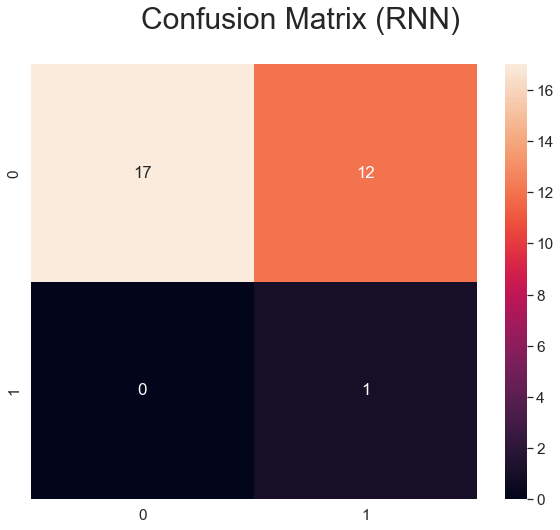

In [19]:
y_pred = model.predict_classes(X_test)
score = model.evaluate(X_test, y_test,verbose=0)

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True)
plt.suptitle('Confusion Matrix (RNN)',fontsize=30)
# plt.savefig("./ConfusionMatrix_RNNLSTM_LabMeaswithtime.jpg", 
#            bbox_inches ="tight", 
#            pad_inches = 1, 
#            transparent = True, 
#            orientation ='landscape') 

print("-----------------------------------------------------------------")
print("Accuracy of RNN Classifier :", accuracy_score(y_test, y_pred))
print("-----------------------------------------------------------------")
matrix = classification_report(y_test,y_pred,labels=[1,0])
print('Classification report : \n',matrix)
print("-----------------------------------------------------------------")

#### Neural Network 6 (Clockwork RNN)

The basic architecture of neural network based on Clockwork RNN. 

In [12]:
print("------------------------------------------------------------")
model = Sequential()
model.add(ClockworkRNN(periods=[1,2,3],
                       units_per_period=10, 
                       input_shape=(None, 1), 
                       output_units=X_train.shape[1]))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
print("------------------------------------------------------------")

------------------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
clockwork_simple_rnn_2 (Cloc (None, 134)               4814      
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              135000    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1001      
Total params: 140,815
Trainable params: 140,815
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------


#### Compiling the Neural Network 6

The compilation of the neural network using loss function as binary crossentropy, optimizer as adam and using accuracy as metric to test the performance of the network.

In [14]:
print("------------------------------------------------------------")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train,y_train,epochs=20, validation_split=0.2)
print("------------------------------------------------------------")

------------------------------------------------------------
Train on 216 samples, validate on 54 samples
Epoch 1/20
216/216 [==============================] - 1s 6ms/step - loss: 0.5766 - acc: 0.7176 - val_loss: 0.6152 - val_acc: 0.6852
Epoch 2/20
216/216 [==============================] - 0s 2ms/step - loss: 0.5296 - acc: 0.7454 - val_loss: 0.6138 - val_acc: 0.7037
Epoch 3/20
216/216 [==============================] - 0s 2ms/step - loss: 0.5253 - acc: 0.7546 - val_loss: 0.5879 - val_acc: 0.7593
Epoch 4/20
216/216 [==============================] - 0s 2ms/step - loss: 0.5360 - acc: 0.7361 - val_loss: 0.5707 - val_acc: 0.7407
Epoch 5/20
216/216 [==============================] - 0s 1ms/step - loss: 0.5268 - acc: 0.7222 - val_loss: 0.5959 - val_acc: 0.7593
Epoch 6/20
216/216 [==============================] - 0s 2ms/step - loss: 0.5010 - acc: 0.7824 - val_loss: 0.6578 - val_acc: 0.6296
Epoch 7/20
216/216 [==============================] - 0s 1ms/step - loss: 0.4848 - acc: 0.7778 - val_l

#### Evaluating the Neural Network 6 on Test set

The trained neural network is evaluated on the test set to check its performance.

------------------------------------------------------------------
Accuracy of CWRNN Classifier : 0.4
------------------------------------------------------------------
Classification report : 
               precision    recall  f1-score   support

           1       0.22      0.15      0.18        13
           0       0.48      0.59      0.53        17

    accuracy                           0.40        30
   macro avg       0.35      0.37      0.35        30
weighted avg       0.37      0.40      0.38        30

------------------------------------------------------------------


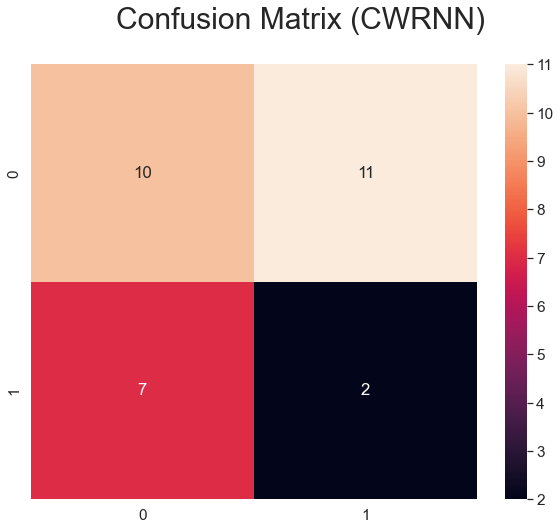

In [15]:
y_pred = model.predict_classes(X_test)
score = model.evaluate(X_test, y_test,verbose=0)

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True)
plt.suptitle('Confusion Matrix (CWRNN)',fontsize=30)
# plt.savefig("./ConfusionMatrix_CWRNN_LabMeaswithtime.jpg", 
#            bbox_inches ="tight", 
#            pad_inches = 1, 
#            transparent = True, 
#            orientation ='landscape')
print("------------------------------------------------------------------")
print("Accuracy of CWRNN Classifier :", accuracy_score(y_test, y_pred))
print("------------------------------------------------------------------")
matrix = classification_report(y_test,y_pred,labels=[1,0])
print('Classification report : \n',matrix)
print("------------------------------------------------------------------")